In [10]:
import pandas as pd
import numpy as np
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Importe a classe de clustering hierárquico
from sklearn.cluster import AgglomerativeClustering
# Importe NearestNeighbors para atribuir pontos de teste
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier

import umap # Import UMAP

import mlflow
# Certifique-se de que a biblioteca static_models está instalada ou disponível
from model2vec import StaticModel # Assumindo que StaticModel é como no seu código
# Assumindo que Embeddings é uma classe base que você definiu ou importou
from langchain.embeddings.base import Embeddings # Assumindo que é de langchain ou similar

In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")  # Ajuste para seu servidor MLflow
mlflow.set_experiment("Train_Emb_Balanced_Synth-Negative_Sentiment_Analysis_Restaurant")

<Experiment: artifact_location='mlflow-artifacts:/816380000824485392', creation_time=1747411527299, experiment_id='816380000824485392', last_update_time=1747411527299, lifecycle_stage='active', name='Train_Emb_Balanced_Synth-Negative_Sentiment_Analysis_Restaurant', tags={}>

In [3]:
# --- Sentence Embedding ---
class Model2VecEmbeddings(Embeddings):
    """Wrapper para o Model2Vec como Embeddings do LangChain"""
    def __init__(self, model_name: str):
        # Certifique-se de ter a biblioteca static_models instalada (pip install static-models)
        self.model = StaticModel.from_pretrained(model_name)

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        # Certifique-se de que texts é uma lista de strings
        return self.model.encode(texts).tolist()

    def embed_query(self, text: str) -> List[float]:
        # Certifique-se de que text é uma string
        return self.model.encode([text]).tolist()[0]

# inputs

In [4]:
# Usando o caminho do seu código
df_train = pd.read_parquet('../data\dataset_train_trim_synthetic_balanced.parquet')

if 'target' not in df_train.columns:
    df_train['target'] = df_train['sentiment']

X_text = df_train['comment_cleaned']
y = df_train['target']

# --- Split de Treino e Teste ---
print("Realizando split de treino/teste...")
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

Realizando split de treino/teste...



Testing embedding model: minishlab/potion-base-8M

Testing clustering with 3 clusters and ward linkage...
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


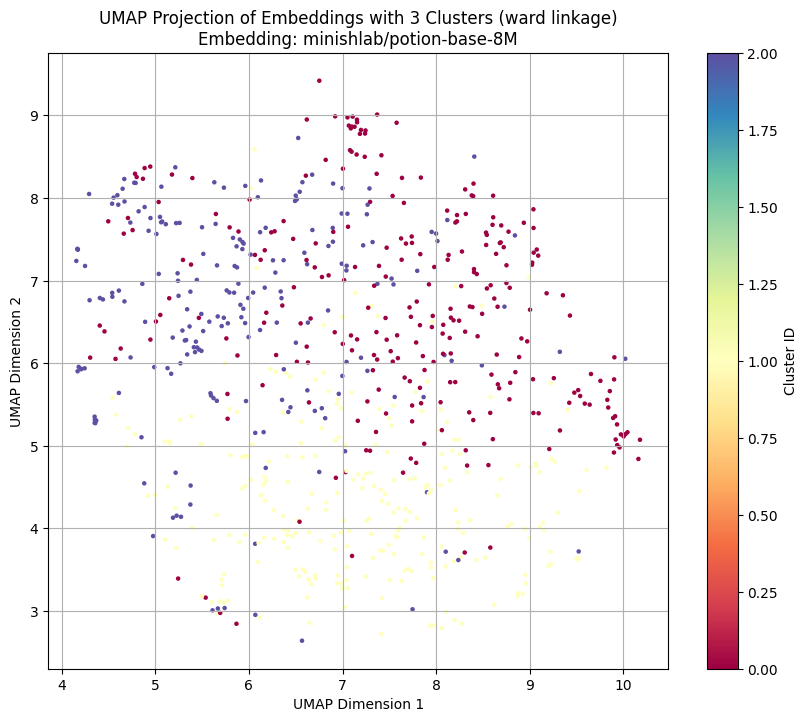

Best recall for LogisticRegression with this config: 1.0

>>> New BEST overall model found! Model: LogisticRegression, Recall (CV): 1.0000
Best parameters for this best model so far: {'model_type': 'LogisticRegression', 'embedding_model': 'minishlab/potion-base-8M', 'n_clusters': 3, 'linkage': 'ward', 'model_params': {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}}
--- Current best model's Test Recall ('Negative'): 1.0000 ---

Testing clustering with 3 clusters and single linkage...
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


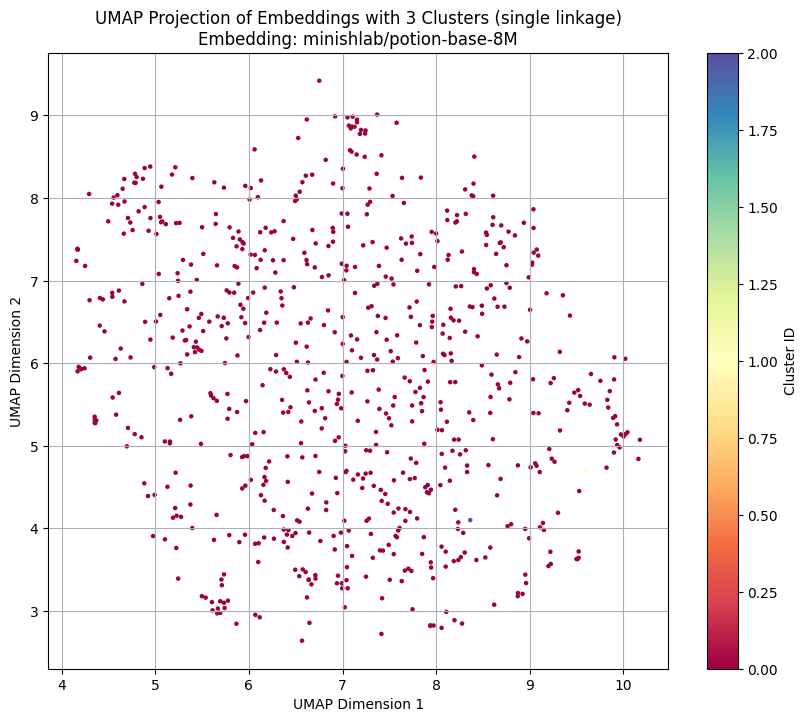

Best recall for LogisticRegression with this config: 1.0

--- Grid search complete! Logging best model to MLflow ---
Best overall parameters found:
{'model_type': 'LogisticRegression', 'embedding_model': 'minishlab/potion-base-8M', 'n_clusters': 3, 'linkage': 'ward', 'model_params': {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}}


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati


Generating Confusion Matrix...


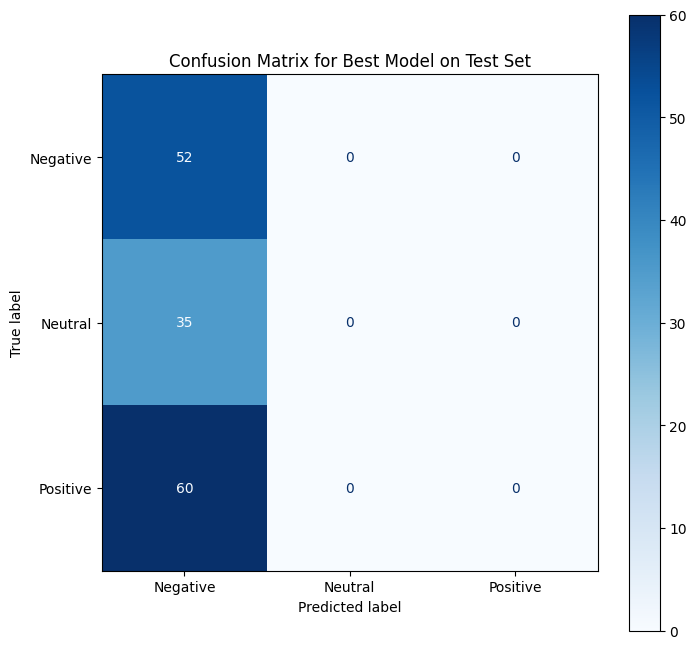

2025/05/16 14:35:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final test recall for negative class ('Negative'): 1.0000
Best model logged to MLflow
🏃 View run GridSearch_Embeddings_Cluster_LogReg_RF at: http://127.0.0.1:5000/#/experiments/816380000824485392/runs/49efb60be8e3447f8234778e70624fa8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/816380000824485392
Script finished!


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
import warnings

ALL_LABELS = ['Negative', 'Neutral', 'Positive']

# --- Função Scorer Customizada para Recall da Classe 'Negative' ---
def recall_negative_scorer_func(y_true, y_pred):
    # Calcula o recall para *todas* as classes presentes, retornando um array.
    # Usamos `labels=ALL_LABELS` para garantir a ordem consistente
    # e `zero_division=0` para que folds sem a classe 'Negative' em y_true resultem em 0.
    per_class_recall = recall_score(y_true, y_pred, average=None, labels=ALL_LABELS, zero_division=0)

    # Encontra o índice da classe 'Negative' na lista ALL_LABELS
    try:
        neg_index = ALL_LABELS.index('Negative')
        # Retorna o recall correspondente a esse índice
        return per_class_recall[neg_index]
    except ValueError:
        # Isso só deve acontecer se 'Negative' não estiver em ALL_LABELS - verifique sua lista!
        print(f"Erro: 'Negative' não encontrado na lista ALL_LABELS: {ALL_LABELS}")
        return np.nan # Retorna NaN para indicar um problema de configuração

# --- Defina nosso scorer usando a função customizada ---
# make_scorer agora usa a função que retorna um único valor (o recall da classe 'Negative')
scorer = make_scorer(recall_negative_scorer_func)

# --- Embedding Models Grid ---
embedding_models = {
    "minishlab/potion-base-8M": Model2VecEmbeddings("minishlab/potion-base-8M")
}

# --- Logistic Regression Hyperparameters Grid ---
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  # These solvers support both L1 and L2
    'max_iter': [500, 1000, 2000]
}

# --- RandomForest Hyperparameters Grid ---
rf_params = {
    'n_estimators': [100, 300, 500], # Número de árvores
    'max_depth': [10, 20, None],     # Profundidade máxima da árvore (None significa sem limite)
    'min_samples_split': [2, 5, 10], # Mínimo de amostras para dividir um nó interno
    'min_samples_leaf': [1, 2, 4],   # Mínimo de amostras em uma folha
    'bootstrap': [True, False],      # Usar amostras bootstrap
    'criterion': ['gini', 'entropy'] # Função para medir a qualidade da divisão
}

# --- Clustering Parameters Grid ---
clustering_params = {
    'n_clusters': [3],
    'linkage': ['ward', 'single']
}

# --- Modelos e seus Grids ---
# Defina um dicionário que mapeia nomes de modelos para seus estimadores e grids de parâmetros
models_to_test = {
    'LogisticRegression': {
        'estimator': LogisticRegression(random_state=42),
        'params': lr_params
    }
    # 'RandomForestClassifier': {
    #     'estimator': RandomForestClassifier(random_state=42),
    #     'params': rf_params
    # }
}

best_recall = 0
best_params = {}
best_model = None
best_X_test_aug = None # Precisamos guardar o X_test_aug do melhor modelo para a avaliação final


# Main grid search loop
for emb_name, emb_model in embedding_models.items():
    print(f"\nTesting embedding model: {emb_name}")
    
    # Generate embeddings
    X_train_vec = np.array(emb_model.embed_documents(X_train_text.tolist()))
    X_test_vec = np.array(emb_model.embed_documents(X_test_text.tolist()))
    
    for n_clusters in clustering_params['n_clusters']:
        for linkage in clustering_params['linkage']:
            print(f"\nTesting clustering with {n_clusters} clusters and {linkage} linkage...")
            
            # Hierarchical clustering
            hc = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
            train_clusters = hc.fit_predict(X_train_vec)
            
            # Assign test clusters using nearest neighbor
            nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
            nn.fit(X_train_vec)
            _, indices = nn.kneighbors(X_test_vec)
            test_clusters = train_clusters[indices.flatten()]
            
            # Augment features
            X_train_aug = np.hstack([X_train_vec, train_clusters.reshape(-1, 1)])
            X_test_aug = np.hstack([X_test_vec, test_clusters.reshape(-1, 1)])
            
            print(f"Shape of augmented training data: {X_train_aug.shape}")
            print(f"Shape of augmented test data: {X_test_aug.shape}")
            
            # Combine train and test embeddings for unified visualization
            # It's often better to fit UMAP on the training data and transform test data
            # to avoid "peeking" at the test set distribution
            X_combined_vec = np.vstack((X_train_vec, X_test_vec))
            all_clusters = np.hstack((train_clusters, test_clusters))

            # Fit UMAP on training data and transform both train and test
            reducer = umap.UMAP(n_components=2, random_state=42) # Reduce to 2 dimensions
            X_embedded = reducer.fit_transform(X_train_vec) # Fit on train

            # Separate embedded train and test points
            X_train_embedded = X_embedded[:len(X_train_vec)]
            X_test_embedded = reducer.transform(X_test_vec) # Transform test

            # Combine embedded train and test for plotting
            X_combined_embedded = np.vstack((X_train_embedded, X_test_embedded))


            import matplotlib.pyplot as plt

            plt.figure(figsize=(10, 8))
            # Scatter plot, coloring points by their assigned cluster ID
            scatter = plt.scatter(X_combined_embedded[:, 0], X_combined_embedded[:, 1], c=all_clusters, cmap='Spectral', s=5) # s=5 for smaller points
            
            # Add colorbar to show cluster IDs
            cbar = plt.colorbar(scatter)
            cbar.set_label('Cluster ID')

            plt.title(f'UMAP Projection of Embeddings with {n_clusters} Clusters ({linkage} linkage)\nEmbedding: {emb_name}')
            plt.xlabel('UMAP Dimension 1')
            plt.ylabel('UMAP Dimension 2')
            plt.grid(True)
            plt.show() # Display the plot
            
            # --- Loop through different model types (LR, RF) ---
            for model_name, model_config in models_to_test.items():
            
                estimator = model_config['estimator']
                param_grid = model_config['params']
                
                grid = GridSearchCV(estimator, param_grid, scoring=scorer, cv=3, n_jobs=-1)
                
                # Suppress potential warnings from grid search/estimator fitting
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore") # Pode silenciar ConvergenceWarning ou outros warnings
                    grid.fit(X_train_aug, y_train)
                
                # Get best score from this GridSearchCV run (for this model type, embedding, clustering)
                current_recall = grid.best_score_
                print(f"Best recall for {model_name} with this config: {current_recall}")
                
                # Track best overall model found so far across all configurations
                if current_recall > best_recall:
                    best_recall = current_recall
                    best_params = {
                        'model_type': model_name,
                        'embedding_model': emb_name,
                        'n_clusters': n_clusters,
                        'linkage': linkage,
                        'model_params': grid.best_params_
                    }
                    best_model = grid.best_estimator_
                    # Guardamos o X_test_aug *dessa iteração* porque ele depende do clustering
                    best_X_test_aug = X_test_aug 
                    
                    print(f"\n>>> New BEST overall model found! Model: {model_name}, Recall (CV): {best_recall:.4f}")
                    print(f"Best parameters for this best model so far: {best_params}")

                    # Opcional: Avaliar no test set *agora* para ver a performance do novo melhor
                    # Note: Isso reavalia o melhor modelo atual no conjunto de teste *dessa iteração*.
                    # A avaliação final no MLflow usará o melhor modelo *global* e o X_test_aug *desse* modelo.
                    y_pred_test = best_model.predict(best_X_test_aug)
                    # Usamos a mesma lógica do scorer para consistência na avaliação do test set
                    per_class_recall_test_best = recall_score(y_test, y_pred_test, average=None, labels=ALL_LABELS)
                    neg_index = ALL_LABELS.index('Negative')
                    current_test_recall = per_class_recall_test_best[neg_index]
                    print(f"--- Current best model's Test Recall ('Negative'): {current_test_recall:.4f} ---")


# --- Log best model to MLflow ---
print("\n--- Grid search complete! Logging best model to MLflow ---")

if best_model is not None:
    with mlflow.start_run(run_name="GridSearch_Embeddings_Cluster_LogReg_RF"):
        print("Best overall parameters found:")
        print(best_params)
        
        # Log parameters
        mlflow.log_params({
            'model_type': best_params['model_type'],
            'embedding_model': best_params['embedding_model'],
            'n_clusters': best_params['n_clusters'],
            'linkage': best_params['linkage'],
            # Log parameters specific to the best model type
            **{f'{best_params["model_type"]}_{k}': v for k, v in best_params['model_params'].items()}
        })
        
        # Log metrics on the test set using the best model and its corresponding X_test_aug
        y_pred = best_model.predict(best_X_test_aug) # Use best_X_test_aug!

        acc = accuracy_score(y_test, y_pred)
        
        # Calculate negative recall using the average=None logic
        per_class_recall_final = recall_score(y_test, y_pred, average=None, labels=ALL_LABELS, zero_division=0)
        neg_index = ALL_LABELS.index('Negative')
        final_neg_recall = per_class_recall_final[neg_index]
        
        report = classification_report(y_test, y_pred, target_names=ALL_LABELS, output_dict=True) # Use target_names


        # Log other metrics per class from the report
        for label in ALL_LABELS:
             if label in report:
                 mlflow.log_metrics({
                     f'precision_{label}': report[label]['precision'],
                     f'recall_{label}': report[label]['recall'],
                     f'f1-score_{label}': report[label]['f1-score'],
                     f'support_{label}': report[label]['support']
                 })
        # Log weighted/macro/micro averages if they exist (they will with output_dict=True)
        for avg in ['macro avg', 'weighted avg']: # <--- Mudei a lista aqui
             if avg in report: # Verifica se a média existe (sempre existe com output_dict=True para >1 classe)
                  # Note: accuracy não é um dicionário, por isso a excluímos deste loop
                  mlflow.log_metrics({
                      f'{avg.replace(" ", "_")}_precision': report[avg]['precision'],
                      f'{avg.replace(" ", "_")}_recall': report[avg]['recall'],
                      f'{avg.replace(" ", "_")}_f1-score': report[avg]['f1-score']
                  })

        # --- Add Confusion Matrix Display ---
        print("\nGenerating Confusion Matrix...")
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        import matplotlib.pyplot as plt

        # Calculate the confusion matrix
        # Ensure labels are ordered correctly using ALL_LABELS
        cm = confusion_matrix(y_test, y_pred, labels=ALL_LABELS)

        # Display the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ALL_LABELS)

        # Plot and show
        fig, ax = plt.subplots(figsize=(8, 8)) # Adjust figure size if needed
        disp.plot(cmap=plt.cm.Blues, ax=ax) # Use a colormap
        plt.title("Confusion Matrix for Best Model on Test Set")
        plt.show() # This will display the plot


        mlflow.log_dict(report, "classification_report.json")
        
        # Log model
        mlflow.sklearn.log_model(best_model, "model")
        
        print(f"Final test recall for negative class ('{ALL_LABELS[neg_index]}'): {final_neg_recall:.4f}")
        print("Best model logged to MLflow")

else:
    print("No valid model found during grid search!")

print("Script finished!")

In [12]:
# Dentro do loop de clustering, APÓS gerar X_train_aug e y_train
if emb_name == "minishlab/potion-base-8M":
    print(f"--- Debugging data for {emb_name}, n_clusters={n_clusters}, linkage={linkage} ---")
    print("Shape of X_train_aug:", X_train_aug.shape)
    print("Are there NaNs in X_train_aug?", np.isnan(X_train_aug).any())
    print("Are there Infs in X_train_aug?", np.isinf(X_train_aug).any())
    print("Min value in X_train_aug:", np.nanmin(X_train_aug) if np.isnan(X_train_aug).any() else X_train_aug.min())
    print("Max value in X_train_aug:", np.nanmax(X_train_aug) if np.isnan(X_train_aug).any() else X_train_aug.max())
    print("Mean value in X_train_aug:", np.nanmean(X_train_aug) if np.isnan(X_train_aug).any() else X_train_aug.mean())
    print("Shape of y_train:", y_train.shape)
    
    #print("Are there NaNs in y_train?", np.isnan(y_train)) # Deve ser False para labels
    print("y_train value counts:", np.unique(y_train, return_counts=True))
    print("-----------------------------------------------------------------")

--- Debugging data for minishlab/potion-base-8M, n_clusters=3, linkage=ward ---
Shape of X_train_aug: (586, 257)
Are there NaNs in X_train_aug? False
Are there Infs in X_train_aug? False
Min value in X_train_aug: -0.4777367413043976
Max value in X_train_aug: 2.0
Mean value in X_train_aug: 0.003265673403434001
Shape of y_train: (586,)
y_train value counts: (array(['Negative', 'Neutral', 'Positive'], dtype=object), array([209, 139, 238], dtype=int64))
-----------------------------------------------------------------



Testing embedding model: minishlab/potion-base-8M

Testing clustering algorithm: AgglomerativeClustering with params: {'linkage': 'ward', 'n_clusters': 3}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for AgglomerativeClustering with params {'linkage': 'ward', 'n_clusters': 3}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\fuedj\AppData\Local\Temp\ipykernel_5080\326473310.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_combined_embedded[:, 0], X_combined_embedded[:, 1], c=point_colors, cmap='Spectral', s=5) # s=5 for smaller points


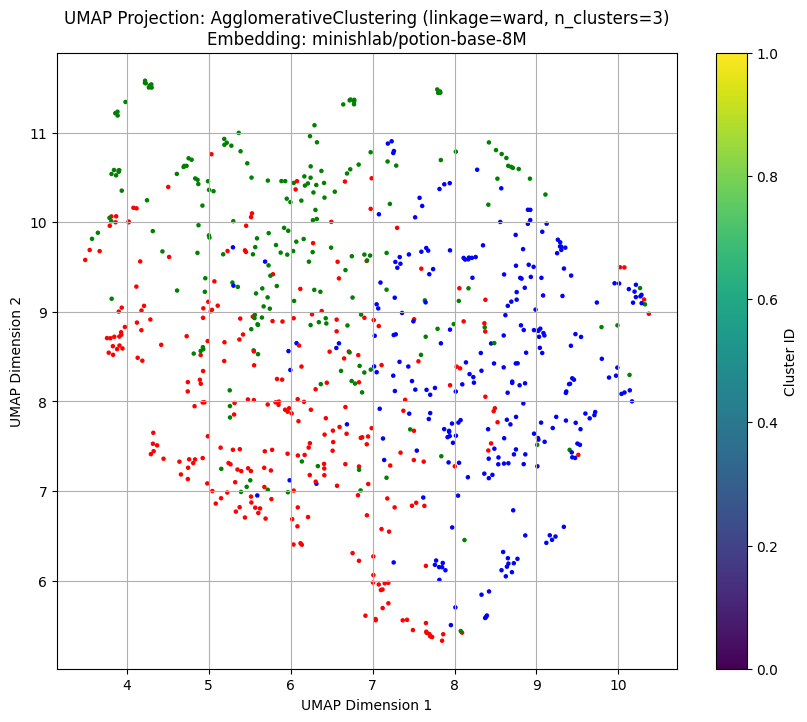


-- Testing classification model: LogisticRegression --
Best CV recall for LogisticRegression with this clustering config: 1.0

>>> New BEST overall model found! Model: LogisticRegression, Clustering: AgglomerativeClustering, Recall (CV): 1.0000
--- Current best model's Test Recall ('Negative'): 1.0000 ---

Testing clustering algorithm: AgglomerativeClustering with params: {'linkage': 'complete', 'n_clusters': 3}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for AgglomerativeClustering with params {'linkage': 'complete', 'n_clusters': 3}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\fuedj\AppData\Local\Temp\ipykernel_5080\326473310.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_combined_embedded[:, 0], X_combined_embedded[:, 1], c=point_colors, cmap='Spectral', s=5) # s=5 for smaller points


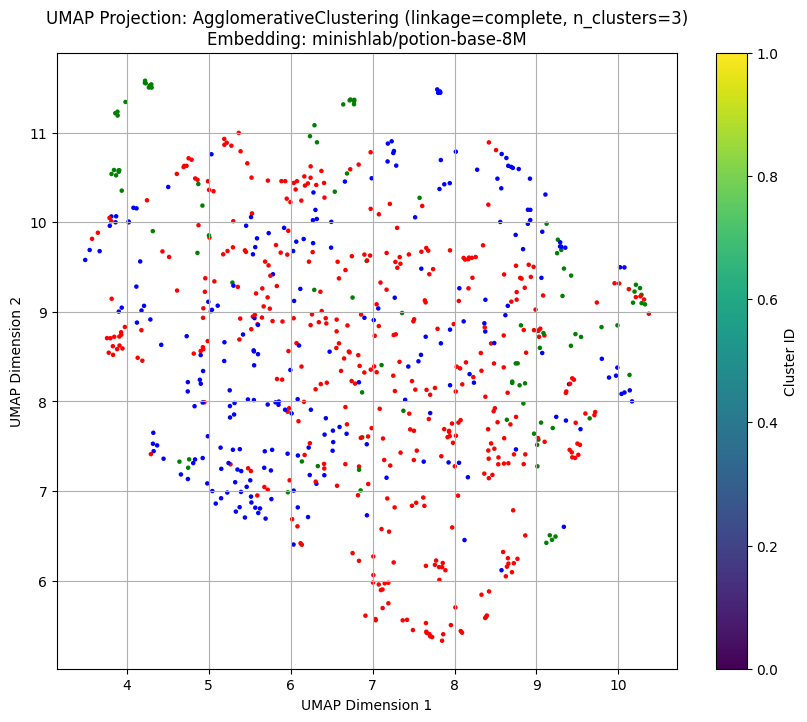


-- Testing classification model: LogisticRegression --
Best CV recall for LogisticRegression with this clustering config: 1.0

Testing clustering algorithm: AgglomerativeClustering with params: {'linkage': 'average', 'n_clusters': 3}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for AgglomerativeClustering with params {'linkage': 'average', 'n_clusters': 3}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\fuedj\AppData\Local\Temp\ipykernel_5080\326473310.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_combined_embedded[:, 0], X_combined_embedded[:, 1], c=point_colors, cmap='Spectral', s=5) # s=5 for smaller points


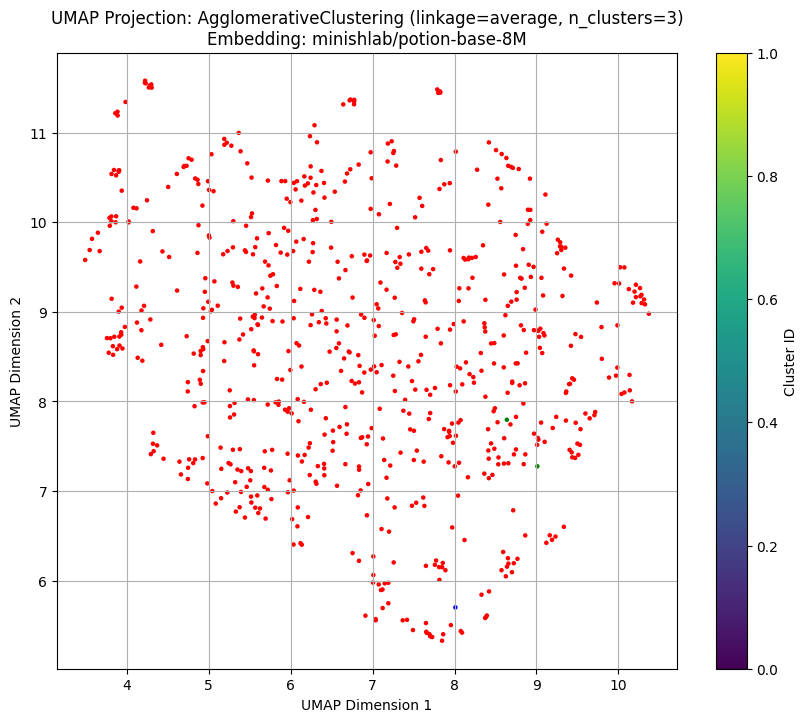


-- Testing classification model: LogisticRegression --
Best CV recall for LogisticRegression with this clustering config: 1.0

Testing clustering algorithm: KMeans with params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for KMeans with params {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\fuedj\AppData\Local\Temp\ipykernel_5080\326473310.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_combined_embedded[:, 0], X_combined_embedded[:, 1], c=point_colors, cmap='Spectral', s=5) # s=5 for smaller points


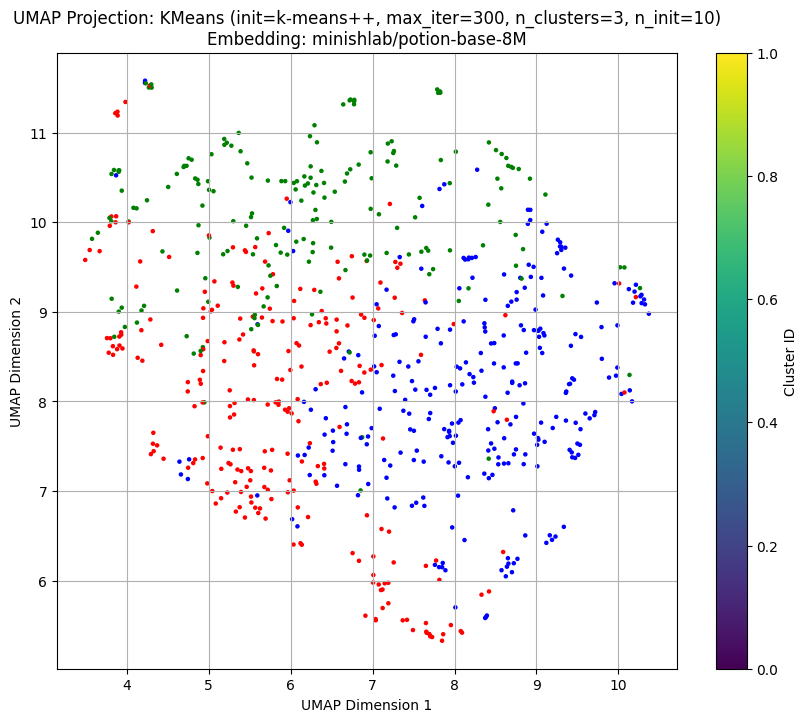


-- Testing classification model: LogisticRegression --
Best CV recall for LogisticRegression with this clustering config: 1.0

Testing clustering algorithm: KMeans with params: {'init': 'random', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for KMeans with params {'init': 'random', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\fuedj\AppData\Local\Temp\ipykernel_5080\326473310.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(X_combined_embedded[:, 0], X_combined_embedded[:, 1], c=point_colors, cmap='Spectral', s=5) # s=5 for smaller points


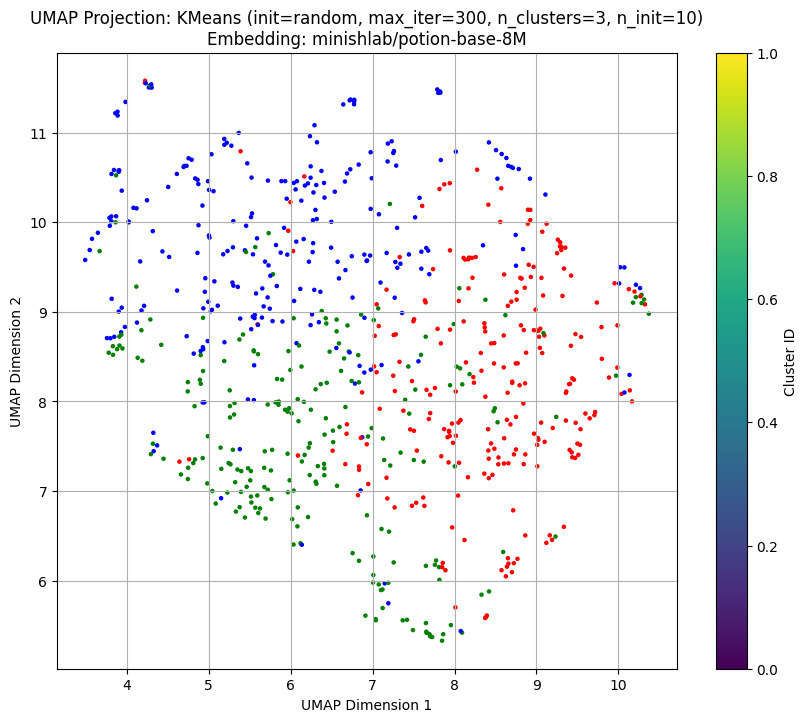


-- Testing classification model: LogisticRegression --
Best CV recall for LogisticRegression with this clustering config: 1.0

--- Grid search complete! Logging best model to MLflow ---
Best overall parameters found:
{'classification_model': 'LogisticRegression', 'embedding_model': 'minishlab/potion-base-8M', 'clustering_algorithm': 'AgglomerativeClustering', 'clustering_params': {'linkage': 'ward', 'n_clusters': 3}, 'classification_model_params': {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}}


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati


Generating Confusion Matrix for Best Model...
Confusion Matrix logged to MLflow artifacts.


2025/05/16 14:55:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final test recall for negative class ('Negative'): 1.0000
Best model logged to MLflow
🏃 View run GridSearch_Embeddings_Cluster_Classifiers at: http://127.0.0.1:5000/#/experiments/816380000824485392/runs/085c9c0cbdbb4cc6b105863096c35a46
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/816380000824485392
Script finished!


In [17]:
import numpy as np
# Certifique-se de que todas as bibliotecas necessárias estão importadas
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans # Import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt # Para visualização
import umap # Para visualização de UMAP (se instalado)
# Supondo que Model2VecEmbeddings e mlflow já estão configurados
# from seu_modulo import Model2VecEmbeddings
import mlflow
import warnings

# --- Defina todos os rótulos possíveis no seu dataset ---
ALL_LABELS = ['Negative', 'Neutral', 'Positive'] # <-- VERIFIQUE SE ESTÁ CORRETO PARA SEUS DADOS

# --- Função Scorer Customizada para Recall da Classe 'Negative' ---
def recall_negative_scorer_func(y_true, y_pred):
    try:
        per_class_recall = recall_score(y_true, y_pred, average=None, labels=ALL_LABELS, zero_division=0)
        neg_index = ALL_LABELS.index('Negative')
        return per_class_recall[neg_index]
    except ValueError as e:
         print(f"Erro no scorer: {e}")
         print(f"y_true unique: {np.unique(y_true)}")
         print(f"y_pred unique: {np.unique(y_pred)}")
         print(f"ALL_LABELS: {ALL_LABELS}")
         return np.nan

scorer = make_scorer(recall_negative_scorer_func)

# --- Embedding Models Grid ---
embedding_models = {
    "minishlab/potion-base-8M": Model2VecEmbeddings("minishlab/potion-base-8M")
    # Adicionar outros embeddings aqui se desejar
}

# --- Clustering Algorithms and Parameters Grid ---
# Definimos uma estrutura para testar diferentes algoritmos de clustering
clustering_configs = {
    "AgglomerativeClustering": {
        "estimator": AgglomerativeClustering,
        "params": {
            'n_clusters': [3],
            'linkage': ['ward', 'complete', 'average']
        }
    },
    "KMeans": { # Adicionamos KMeans
        "estimator": KMeans,
        "params": {
            'n_clusters': [3],
            'init': ['k-means++', 'random'], # Como inicializar os centróides
            'n_init': [10], # Número de vezes para rodar com diferentes inicializações (evita mínimos locais)
            'max_iter': [300] # Iterações máximas para cada run (default é 300)
        }
    }
    # Adicionar outros algoritmos aqui se desejar (ex: Birch)
    # "Birch": {
    #     "estimator": Birch,
    #     "params": {
    #          'n_clusters': [3, 5],
    #          'threshold': [0.5] # Exemplo de outro parâmetro
    #      }
    # }
}


# --- Logistic Regression Hyperparameters Grid ---
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000, 2000]
}

# --- RandomForest Hyperparameters Grid ---
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# --- Classification Models and their Grids ---
models_to_test = {
    'LogisticRegression': {
        'estimator': LogisticRegression(random_state=42),
        'params': lr_params
    }
}


best_recall = -1
best_params = {}
best_model = None
best_X_test_aug = None

# Main grid search loop
for emb_name, emb_model in embedding_models.items():
    print(f"\nTesting embedding model: {emb_name}")
    
    # Generate embeddings (Uma vez por embedding model)
    X_train_vec = np.array(emb_model.embed_documents(X_train_text.tolist()))
    X_test_vec = np.array(emb_model.embed_documents(X_test_text.tolist()))

    # --- Loop through different clustering algorithms and their parameter grids ---
    for cluster_algo_name, cluster_config in clustering_configs.items():
        cluster_estimator_cls = cluster_config["estimator"] # A classe do estimador (ex: AgglomerativeClustering, KMeans)
        cluster_params_grid = cluster_config["params"]      # O grid de parâmetros para este algoritmo

        # Usamos ParameterGrid para iterar sobre todas as combinações de parâmetros do clustering
        from sklearn.model_selection import ParameterGrid
        cluster_param_combinations = list(ParameterGrid(cluster_params_grid))

        for cluster_params in cluster_param_combinations:
            print(f"\nTesting clustering algorithm: {cluster_algo_name} with params: {cluster_params}...")

            # --- Perform Clustering ---
            # Instancia o algoritmo de clustering com os parâmetros atuais da combinação
            # Para KMeans, é bom adicionar random_state para reprodutibilidade
            if cluster_algo_name == "KMeans":
                hc = cluster_estimator_cls(random_state=42, **cluster_params)
            else: # Para AgglomerativeClustering e outros que podem não ter random_state no construtor
                 hc = cluster_estimator_cls(**cluster_params)


            # Suppress potential warnings from clustering
            with warnings.catch_warnings():
                 warnings.simplefilter("ignore")
                 # Fit e predict nos dados de treino para obter os rótulos dos clusters de treino
                 # KMeans tem fit_predict, AgglomerativeClustering também.
                 # Alguns algoritmos podem precisar de fit().labels_
                 try:
                     train_clusters = hc.fit_predict(X_train_vec)
                 except TypeError: # Alguns algoritmos podem não ter fit_predict direto
                      hc.fit(X_train_vec)
                      train_clusters = hc.labels_


            # Verifique quantos clusters foram realmente formados
            unique_train_clusters = np.unique(train_clusters)
            print(f"INFO: Clustering resulted in {len(unique_train_clusters)} actual clusters (requested {cluster_params.get('n_clusters', 'N/A')}). Unique labels: {unique_train_clusters}")

            # --- Assign test clusters using nearest neighbor ---
            # NOTE: O NearestNeighbors continua sendo usado para atribuir rótulos de treino
            # aos pontos de teste, independente do algoritmo de clustering usado para gerar
            # os rótulos de treino.
            nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
            nn.fit(X_train_vec) # Fit NN nos embeddings de treino
            _, indices = nn.kneighbors(X_test_vec) # Encontra vizinho mais próximo de cada ponto de teste nos pontos de treino
            test_clusters = train_clusters[indices.flatten()] # Atribui o cluster ID do vizinho mais próximo de treino


            # --- Augment features ---
            # Adiciona o ID do cluster como uma nova feature (garante que seja uma feature)
            X_train_aug = np.hstack([X_train_vec, train_clusters.reshape(-1, 1)])
            X_test_aug = np.hstack([X_test_vec, test_clusters.reshape(-1, 1)])

            print(f"Shape of augmented training data: {X_train_aug.shape}")
            print(f"Shape of augmented test data: {X_test_aug.shape}")

            # --- Optional: Visualize Clusters using UMAP (Adjust/comment as needed) ---
            # Rode isso apenas para algumas configurações se a lista for longa
            # if cluster_algo_name == "KMeans" and cluster_params['n_clusters'] == 3 and cluster_params['n_init'] == 10: # Exemplo: visualize só para 3 clusters Kmeans
            # if cluster_algo_name == "AgglomerativeClustering" and cluster_params['n_clusters'] == 3 and cluster_params['linkage'] == 'ward': # Exemplo: visualize só para 3 ward

            # Comente esta seção se não quiser ver os plots de UMAP durante a execução
            try:
                print(f"Visualizing clusters for {cluster_algo_name} with params {cluster_params}...")
                
                X_combined_vec = np.vstack((X_train_vec, X_test_vec))
                all_clusters = np.hstack((train_clusters, test_clusters))

                reducer = umap.UMAP(n_components=2, random_state=42) # Reduce to 2 dimensions
                # Fit UMAP on the full combined data for a global view, or just train if preferred
                X_combined_embedded = reducer.fit_transform(X_combined_vec)
                cluster_color_map = {
                    0: 'red',
                    1: 'blue',
                    2: 'green'
                }
                point_colors = [cluster_color_map[cid] for cid in all_clusters]
                plt.figure(figsize=(10, 8))
                scatter = plt.scatter(X_combined_embedded[:, 0], X_combined_embedded[:, 1], c=point_colors, cmap='Spectral', s=5) # s=5 for smaller points

                cbar = plt.colorbar(scatter)
                cbar.set_label('Cluster ID')

                # Criar um título descritivo para o plot de UMAP
                cluster_param_str = ", ".join([f"{k}={v}" for k, v in cluster_params.items()])
                plt.title(f'UMAP Projection: {cluster_algo_name} ({cluster_param_str})\nEmbedding: {emb_name}')
                plt.xlabel('UMAP Dimension 1')
                plt.ylabel('UMAP Dimension 2')
                plt.grid(True)
                plt.show()

            except Exception as e:
                print(f"Warning: Could not generate UMAP plot for this config: {e}")
                # Certifique-se de fechar a figura se não for mostrada para evitar uso de memória
                # plt.close('all') # Pode ser útil se houver muitos plots

            # --- End Cluster Visualization ---


            # --- Loop through different classification model types (LR, RF) ---
            for model_name, model_config in models_to_test.items():
                print(f"\n-- Testing classification model: {model_name} --")
                estimator = model_config['estimator']
                param_grid = model_config['params']

                # Execute GridSearchCV para o modelo de classificação com os dados aumentados atuais
                grid = GridSearchCV(estimator, param_grid, scoring=scorer, cv=3, n_jobs=-1)

                # Suppress potential warnings from grid search/estimator fitting
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    try:
                        grid.fit(X_train_aug, y_train)
                    except ValueError as e:
                         print(f"ERROR during GridSearchCV fit for {model_name} with clustering {cluster_algo_name} {cluster_params}: {e}")
                         print("Skipping this classification model configuration.")
                         continue # Pule para o próximo modelo de classificação ou configuração de clustering

                # Get best score from this GridSearchCV run
                current_recall = grid.best_score_
                print(f"Best CV recall for {model_name} with this clustering config: {current_recall}")

                # Track best overall model found so far
                if current_recall is not None and not np.isnan(current_recall) and current_recall > best_recall:
                    best_recall = current_recall
                    best_params = {
                        'classification_model': model_name,
                        'embedding_model': emb_name,
                        'clustering_algorithm': cluster_algo_name,
                        'clustering_params': cluster_params, # Salva os parâmetros específicos do clustering
                        'classification_model_params': grid.best_params_ # Salva os parâmetros específicos do classificador
                    }
                    best_model = grid.best_estimator_
                    best_X_test_aug = X_test_aug

                    print(f"\n>>> New BEST overall model found! Model: {model_name}, Clustering: {cluster_algo_name}, Recall (CV): {best_recall:.4f}")
                    # Opcional: Avaliar no test set AGORA para ver a performance do novo melhor
                    # Usamos a mesma lógica do scorer para consistência na avaliação do test set
                    try:
                         y_pred_test = best_model.predict(best_X_test_aug)
                         per_class_recall_test_best = recall_score(y_test, y_pred_test, average=None, labels=ALL_LABELS, zero_division=0)
                         neg_index = ALL_LABELS.index('Negative')
                         current_test_recall = per_class_recall_test_best[neg_index]
                         print(f"--- Current best model's Test Recall ('Negative'): {current_test_recall:.4f} ---")
                    except Exception as e:
                         print(f"Warning: Could not evaluate current best model on test set: {e}")


# --- Log best model to MLflow ---
print("\n--- Grid search complete! Logging best model to MLflow ---")

if best_model is not None:
    with mlflow.start_run(run_name="GridSearch_Embeddings_Cluster_Classifiers"):
        print("Best overall parameters found:")
        print(best_params)
        
        # Log parameters
        logged_params = {
            'classification_model': best_params['classification_model'],
            'embedding_model': best_params['embedding_model'],
            'clustering_algorithm': best_params['clustering_algorithm'],
            # Log parâmetros específicos do clustering
            **{f'clustering_{k}': v for k, v in best_params['clustering_params'].items()},
            # Log parâmetros específicos do classificador
            **{f'{best_params["classification_model"]}_{k}': v for k, v in best_params['classification_model_params'].items()}
        }
        mlflow.log_params(logged_params)

        # Log metrics on the test set using the best model and its corresponding X_test_aug
        y_pred = best_model.predict(best_X_test_aug)

        acc = accuracy_score(y_test, y_pred)

        per_class_recall_final = recall_score(y_test, y_pred, average=None, labels=ALL_LABELS, zero_division=0)
        neg_index = ALL_LABELS.index('Negative')
        final_neg_recall = per_class_recall_final[neg_index]

        report = classification_report(y_test, y_pred, target_names=ALL_LABELS, output_dict=True)

        # mlflow.log_metrics({
        #     'accuracy': acc,
        #     'recall_negative': final_neg_recall,
        #     'best_cv_recall_negative': best_recall
        # })

        for label in ALL_LABELS:
             if label in report:
                 mlflow.log_metrics({
                     f'precision_{label}': report[label]['precision'],
                     f'recall_{label}': report[label]['recall'],
                     f'f1-score_{label}': report[label]['f1-score'],
                     f'support_{label}': report[label]['support']
                 })

        # Log médias (macro e weighted)
        for avg in ['macro avg', 'weighted avg']:
             if avg in report: # Verifica se a média existe (sempre existe com output_dict=True para >1 classe)
                  mlflow.log_metrics({
                      f'{avg.replace(" ", "_")}_precision': report[avg]['precision'],
                      f'{avg.replace(" ", "_")}_recall': report[avg]['recall'],
                      f'{avg.replace(" ", "_")}_f1-score': report[avg]['f1-score']
                  })
        mlflow.log_dict(report, "classification_report.json")

        # --- Generate and Log Confusion Matrix ---
        print("\nGenerating Confusion Matrix for Best Model...")
        # Ensure labels are ordered correctly using ALL_LABELS
        cm = confusion_matrix(y_test, y_pred, labels=ALL_LABELS)

        # Use matplotlib to plot the matrix
        fig, ax = plt.subplots(figsize=(8, 8))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ALL_LABELS)
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title("Confusion Matrix for Best Model on Test Set")

        # Save the plot as an artifact and log it to MLflow
        cm_plot_path = "confusion_matrix.png"
        plt.savefig(cm_plot_path)
        mlflow.log_artifact(cm_plot_path)
        plt.close(fig) # Close the figure
        plt.show(fig)
        
        print("Confusion Matrix logged to MLflow artifacts.")
        # --- End Confusion Matrix Code ---

        # Log model
        mlflow.sklearn.log_model(best_model, "model")

        print(f"Final test recall for negative class ('{ALL_LABELS[neg_index]}'): {final_neg_recall:.4f}")
        print("Best model logged to MLflow")

else:
    print("No valid model found during grid search!")

print("Script finished!")


Testing embedding model: minishlab/potion-base-8M

Testing clustering algorithm: AgglomerativeClustering with params: {'linkage': 'ward', 'n_clusters': 3}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for AgglomerativeClustering with params {'linkage': 'ward', 'n_clusters': 3}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


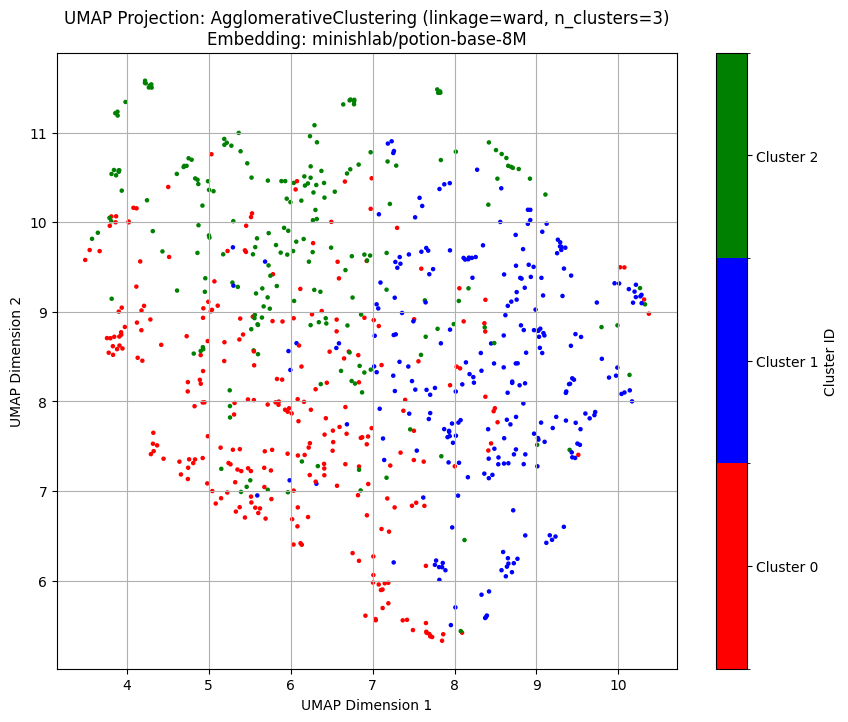


-- Testing classification model: LogisticRegression --
Best params for LogisticRegression with this clustering: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Scores for this config (based on refit='recall_negative'):
  Recall Negative: 1.0000
  Accuracy: 0.3567
  Precision Negative: 0.3567

>>> New BEST overall model (by recall_negative) found! Model: LogisticRegression, Clustering: AgglomerativeClustering, Recall (CV): 1.0000

Testing clustering algorithm: AgglomerativeClustering with params: {'linkage': 'complete', 'n_clusters': 3}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for AgglomerativeClustering with params {'linkage': 'complete', 'n_clusters': 3}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


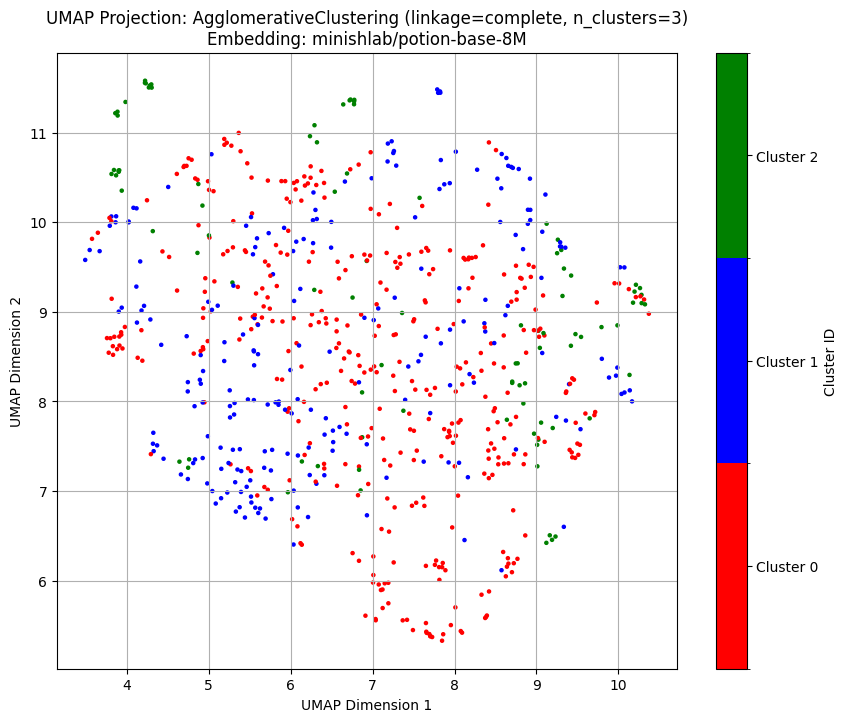


-- Testing classification model: LogisticRegression --
Best params for LogisticRegression with this clustering: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Scores for this config (based on refit='recall_negative'):
  Recall Negative: 1.0000
  Accuracy: 0.3567
  Precision Negative: 0.3567

Testing clustering algorithm: AgglomerativeClustering with params: {'linkage': 'average', 'n_clusters': 3}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for AgglomerativeClustering with params {'linkage': 'average', 'n_clusters': 3}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


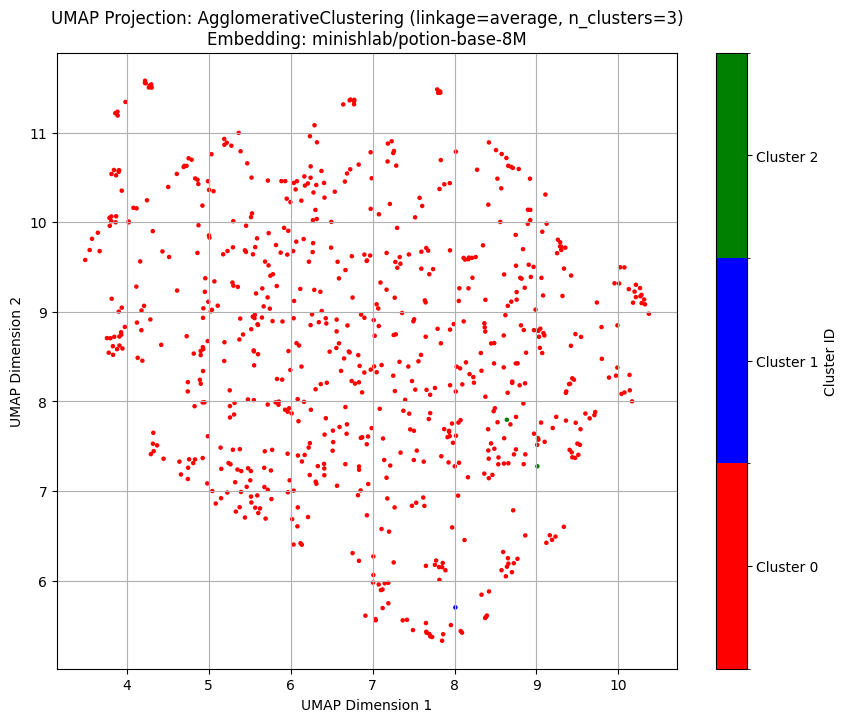


-- Testing classification model: LogisticRegression --
Best params for LogisticRegression with this clustering: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Scores for this config (based on refit='recall_negative'):
  Recall Negative: 1.0000
  Accuracy: 0.3567
  Precision Negative: 0.3567

Testing clustering algorithm: KMeans with params: {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for KMeans with params {'init': 'k-means++', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


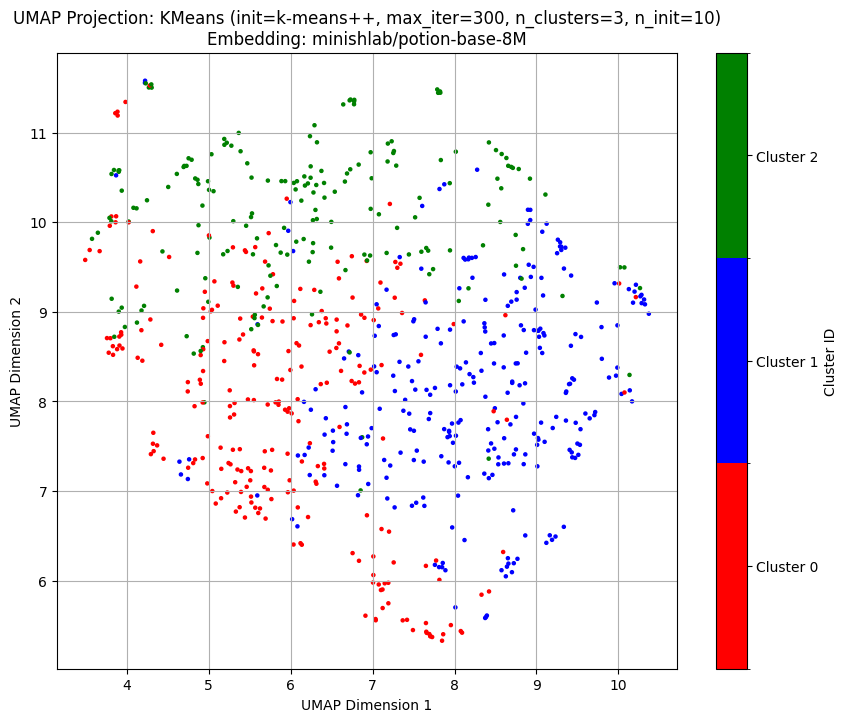


-- Testing classification model: LogisticRegression --
Best params for LogisticRegression with this clustering: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Scores for this config (based on refit='recall_negative'):
  Recall Negative: 1.0000
  Accuracy: 0.3567
  Precision Negative: 0.3567

Testing clustering algorithm: KMeans with params: {'init': 'random', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}...
INFO: Clustering resulted in 3 actual clusters (requested 3). Unique labels: [0 1 2]
Shape of augmented training data: (586, 257)
Shape of augmented test data: (147, 257)
Visualizing clusters for KMeans with params {'init': 'random', 'max_iter': 300, 'n_clusters': 3, 'n_init': 10}...


C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


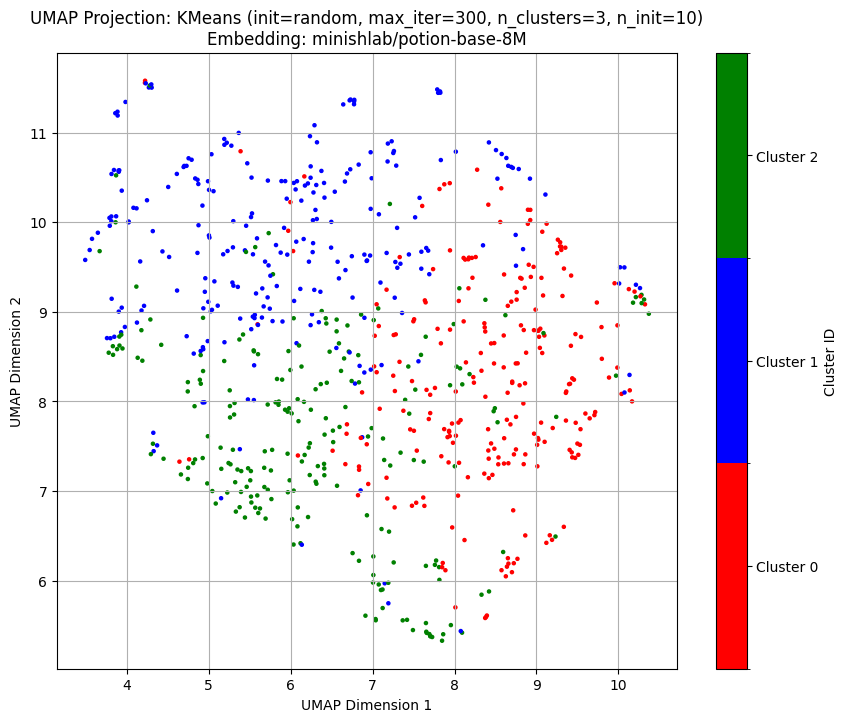


-- Testing classification model: LogisticRegression --
Best params for LogisticRegression with this clustering: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Scores for this config (based on refit='recall_negative'):
  Recall Negative: 1.0000
  Accuracy: 0.3567
  Precision Negative: 0.3567

--- Analyzing Multi-Metric Grid Search Results ---

Analyzing all trained models to select the final best one based on multiple metrics...

--- Re-training the final selected best model ---
Selected configuration:
{'embedding_model': 'minishlab/potion-base-8M', 'clustering_algorithm': 'AgglomerativeClustering', 'clustering_params': {'linkage': 'ward', 'n_clusters': 3}, 'classification_model': 'LogisticRegression'}
Selected classification parameters:
{'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}

Generating augmented data for final configuration (Embedding: minishlab/potion-base-8M, Clustering: AgglomerativeClustering, Params: {'linkage': 'ward',

C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\fuedj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati


Generating Confusion Matrix for Final Selected Model...
Confusion Matrix logged to MLflow artifacts.


2025/05/16 15:00:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final Test Recall ('Negative'): 1.0000
Final Test Accuracy: 0.3537
Best model logged to MLflow
🏃 View run FinalModel_SelectedBy_RecallNeg_and_AccuracyThreshold_0.7 at: http://127.0.0.1:5000/#/experiments/816380000824485392/runs/ead54b1bf9e44c1c80330edd8b106ec7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/816380000824485392

Script finished!


In [20]:
import numpy as np
# Certifique-se de que todas as bibliotecas necessárias estão importadas
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (
    make_scorer, recall_score, accuracy_score, precision_score, f1_score, # Importe outras métricas
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm # Para visualização controlada de cores
import umap # Para visualização de UMAP (se instalado)
# Supondo que Model2VecEmbeddings e mlflow já estão configurados
# from seu_modulo import Model2VecEmbeddings
import mlflow
import warnings

# --- Defina todos os rótulos possíveis no seu dataset ---
ALL_LABELS = ['Negative', 'Neutral', 'Positive'] # <-- VERIFIQUE SE ESTÁ CORRETO PARA SEUS DADOS

# --- Função Scorer Customizada para Recall da Classe 'Negative' ---
# Mantida como antes
def recall_negative_scorer_func(y_true, y_pred):
    try:
        per_class_recall = recall_score(y_true, y_pred, average=None, labels=ALL_LABELS, zero_division=0)
        neg_index = ALL_LABELS.index('Negative')
        return per_class_recall[neg_index]
    except ValueError as e:
         print(f"Erro no scorer (recall_negative): {e}")
         return np.nan

# --- Função Scorer Customizada para Acurácia ---
# A acurácia padrão de sklearn.metrics já funciona para multiclasse,
# mas definimos um scorer explícito para incluí-la no dicionário de scorers.
def accuracy_scorer_func(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# --- Função Scorer Customizada para Precision da Classe 'Negative' ---
def precision_negative_scorer_func(y_true, y_pred):
     try:
        # similar ao recall, mas para precision
        per_class_precision = precision_score(y_true, y_pred, average=None, labels=ALL_LABELS, zero_division=0)
        neg_index = ALL_LABELS.index('Negative')
        return per_class_precision[neg_index]
     except ValueError as e:
         print(f"Erro no scorer (precision_negative): {e}")
         return np.nan

# --- Definir Múltiplos Scorers ---
# Crie um dicionário com todas as métricas de interesse para o GridSearchCV
scorers = {
    'recall_negative': make_scorer(recall_negative_scorer_func),
    'accuracy': make_scorer(accuracy_scorer_func),
    'precision_negative': make_scorer(precision_negative_scorer_func)
    # Adicione outras métricas se desejar (ex: 'f1_negative': make_scorer(f1_score, pos_label='Negative', average='binary', zero_division=0) )
    # Note: Para f1_score da classe 'Negative' com average='binary', a mesma questão multiclasse pode ocorrer.
    # Uma função customizada para f1_negative (similar a recall_negative_scorer_func) seria mais robusta.
    # Exemplo:
    # 'f1_negative': make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average=None, labels=ALL_LABELS, zero_division=0)[ALL_LABELS.index('Negative')])
}


# --- Embedding Models Grid ---
embedding_models = {
    "minishlab/potion-base-8M": Model2VecEmbeddings("minishlab/potion-base-8M")
}

# --- Clustering Algorithms and Parameters Grid ---
clustering_configs = {
    "AgglomerativeClustering": {
        "estimator": AgglomerativeClustering,
        "params": {
            'n_clusters': [3], # Focando em 3 clusters, como você mencionou
            'linkage': ['ward', 'complete', 'average']
        }
    },
    "KMeans": {
        "estimator": KMeans,
        "params": {
            'n_clusters': [3], # Focando em 3 clusters
            'init': ['k-means++', 'random'],
            'n_init': [10],
            'max_iter': [300]
        }
    }
}

# --- Classification Models and their Grids ---
# (Mantidos como antes, mas pode adicionar mais parâmetros)
lr_params = { 'C': [0.01, 0.1], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'], 'max_iter': [500] }
rf_params = { 'n_estimators': [100, 300, 500], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'] }

models_to_test = {
    'LogisticRegression': { 'estimator': LogisticRegression(random_state=42), 'params': lr_params }
}


# --- Variáveis para rastrear o MELHOR modelo GLOBAL (em recall_negative) ---
best_recall = -1
best_params = {}
best_model = None
best_X_test_aug = None

# --- Variáveis para rastrear o MELHOR modelo por GRID SEARCH (para análise multi-métrica) ---
# Vamos guardar os resultados brutos do GridSearchCV para análise posterior
all_grid_search_results = []


# Main grid search loop
for emb_name, emb_model in embedding_models.items():
    print(f"\nTesting embedding model: {emb_name}")
    
    X_train_vec = np.array(emb_model.embed_documents(X_train_text.tolist()))
    X_test_vec = np.array(emb_model.embed_documents(X_test_text.tolist()))

    for cluster_algo_name, cluster_config in clustering_configs.items():
        cluster_estimator_cls = cluster_config["estimator"]
        cluster_params_grid = cluster_config["params"]
        cluster_param_combinations = list(ParameterGrid(cluster_params_grid))

        for cluster_params in cluster_param_combinations:
            print(f"\nTesting clustering algorithm: {cluster_algo_name} with params: {cluster_params}...")

            # --- Perform Clustering ---
            if cluster_algo_name == "KMeans":
                hc = cluster_estimator_cls(random_state=42, **cluster_params)
            else:
                 hc = cluster_estimator_cls(**cluster_params)

            with warnings.catch_warnings():
                 warnings.simplefilter("ignore")
                 try:
                     train_clusters = hc.fit_predict(X_train_vec)
                 except TypeError:
                      hc.fit(X_train_vec)
                      train_clusters = hc.labels_

            unique_train_clusters = np.unique(train_clusters)
            print(f"INFO: Clustering resulted in {len(unique_train_clusters)} actual clusters (requested {cluster_params.get('n_clusters', 'N/A')}). Unique labels: {unique_train_clusters}")

            # --- Assign test clusters ---
            nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
            nn.fit(X_train_vec)
            _, indices = nn.kneighbors(X_test_vec)
            test_clusters = train_clusters[indices.flatten()]

            # --- Augment features ---
            X_train_aug = np.hstack([X_train_vec, train_clusters.reshape(-1, 1)])
            X_test_aug = np.hstack([X_test_vec, test_clusters.reshape(-1, 1)])

            print(f"Shape of augmented training data: {X_train_aug.shape}")
            print(f"Shape of augmented test data: {X_test_aug.shape}")

            # --- Optional: Visualize Clusters using UMAP ---
            # (Mantido como antes, com opção 1 de cores)
            try:
                print(f"Visualizing clusters for {cluster_algo_name} with params {cluster_params}...")
                
                X_combined_vec = np.vstack((X_train_vec, X_test_vec))
                all_clusters = np.hstack((train_clusters, test_clusters))

                reducer = umap.UMAP(n_components=2, random_state=42)
                X_combined_embedded = reducer.fit_transform(X_combined_vec)

                plt.figure(figsize=(10, 8))

                # Define cores e norma para 3 clusters (IDs 0, 1, 2)
                colors = ['red', 'blue', 'green']
                cmap = ListedColormap(colors)
                bounds = [0, 1, 2, 3]
                norm = BoundaryNorm(bounds, cmap.N)

                scatter = plt.scatter(X_combined_embedded[:, 0], X_combined_embedded[:, 1], c=all_clusters, cmap=cmap, norm=norm, s=5)
                
                cbar = plt.colorbar(scatter, ticks=[0.5, 1.5, 2.5])
                cbar.set_ticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])
                cbar.set_label('Cluster ID')

                cluster_param_str = ", ".join([f"{k}={v}" for k, v in cluster_params.items()])
                plt.title(f'UMAP Projection: {cluster_algo_name} ({cluster_param_str})\nEmbedding: {emb_name}')
                plt.xlabel('UMAP Dimension 1')
                plt.ylabel('UMAP Dimension 2')
                plt.grid(True)
                plt.show()

            except Exception as e:
                print(f"Warning: Could not generate UMAP plot for this config: {e}")


            # --- Loop through different classification model types (LR, RF) ---
            for model_name, model_config in models_to_test.items():
                print(f"\n-- Testing classification model: {model_name} --")
                estimator = model_config['estimator']
                param_grid = model_config['params']

                # Execute GridSearchCV com MÚLTIPLAS métricas
                # refit='recall_negative' significa que grid.best_estimator_
                # e grid.best_score_ serão baseados na melhor recall_negative
                grid = GridSearchCV(estimator, param_grid, scoring=scorers, refit='recall_negative', cv=3, n_jobs=-1)

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    try:
                        grid.fit(X_train_aug, y_train)
                    except ValueError as e:
                         print(f"ERROR during GridSearchCV fit for {model_name} with clustering {cluster_algo_name} {cluster_params}: {e}")
                         print("Skipping this classification model configuration.")
                         continue

                # --- Armazenar Resultados Detalhados do GridSearchCV ---
                # Guardamos informações sobre esta run do GridSearchCV para análise posterior
                # Isso permite que você escolha o "melhor" modelo de forma mais sofisticada
                # do que apenas o melhor recall negativo.
                all_grid_search_results.append({
                    'embedding_model': emb_name,
                    'clustering_algorithm': cluster_algo_name,
                    'clustering_params': cluster_params,
                    'classification_model': model_name,
                    'classification_params_grid': param_grid, # Guarda o grid que foi testado
                    'cv_results': grid.cv_results_, # Contém as pontuações de TODAS as métricas para TODOS os parâmetros
                    'best_cv_params': grid.best_params_, # Parâmetros que deram o melhor refit_score
                    'best_cv_recall_negative_score': grid.best_score_, # Melhor score da métrica de refit
                    'grid_estimator': grid.best_estimator_ # O estimador treinado com os best_cv_params
                })

                # Opcional: Imprimir as melhores métricas para esta configuração (Embedding+Clustering+Modelo)
                print(f"Best params for {model_name} with this clustering: {grid.best_params_}")
                print(f"Best CV Scores for this config (based on refit='recall_negative'):")
                # Encontra o índice do melhor modelo com base no refit metric
                best_index = grid.cv_results_['rank_test_recall_negative'].argmin()
                print(f"  Recall Negative: {grid.cv_results_['mean_test_recall_negative'][best_index]:.4f}")
                print(f"  Accuracy: {grid.cv_results_['mean_test_accuracy'][best_index]:.4f}")
                print(f"  Precision Negative: {grid.cv_results_['mean_test_precision_negative'][best_index]:.4f}")


                # --- Atualizar o MELHOR modelo GLOBAL (baseado no recall_negative por enquanto) ---
                # Mantemos esta lógica para rastrear o modelo com o melhor recall negativo *global*
                # Você pode modificar esta lógica APÓS o loop para selecionar o melhor modelo
                # com base em critérios múltiplos, analisando `all_grid_search_results`.
                current_recall = grid.best_score_ # grid.best_score_ é o do refit='recall_negative'
                if current_recall is not None and not np.isnan(current_recall) and current_recall > best_recall:
                    best_recall = current_recall
                    # Note: best_params e best_model aqui ainda refletem APENAS o melhor recall_negative
                    best_params = {
                        'classification_model': model_name,
                        'embedding_model': emb_name,
                        'clustering_algorithm': cluster_algo_name,
                        'clustering_params': cluster_params,
                        'classification_model_params': grid.best_params_
                    }
                    best_model = grid.best_estimator_
                    best_X_test_aug = X_test_aug

                    print(f"\n>>> New BEST overall model (by recall_negative) found! Model: {model_name}, Clustering: {cluster_algo_name}, Recall (CV): {best_recall:.4f}")


# --- Análise Multi-Métrica e Seleção Final do Modelo ---
print("\n--- Analyzing Multi-Metric Grid Search Results ---")

# Agora, `all_grid_search_results` contém os resultados de todos os GridSearchCV.
# Você pode analisar este objeto para escolher o MELHOR modelo final
# com base em recall_negative E acurácia (ou outros critérios).

# Exemplo de como analisar e selecionar:
# Encontre a combinação de parâmetros que maximize recall_negative
# MAS que tenha uma acurácia acima de um certo limite (ex: 0.7)

final_best_model_info = None
best_combined_score = -1 # Use uma métrica combinada ou um critério multi-objetivo

# Iterar sobre os resultados de cada GridSearchCV (uma por combinação emb+cluster+classifier)
for result_entry in all_grid_search_results:
    cv_results = result_entry['cv_results']
    # Iterar sobre cada combinação de parâmetros *dentro* deste GridSearchCV
    for i in range(len(cv_results['params'])):
        params = cv_results['params'][i]
        mean_recall = cv_results['mean_test_recall_negative'][i]
        mean_accuracy = cv_results['mean_test_accuracy'][i]
        # mean_precision = cv_results['mean_test_precision_negative'][i] # Se quiser usar precision

        # --- Defina seu critério de seleção final aqui ---
        # Exemplo 1: Melhor recall negativo entre modelos com acurácia > 0.7
        accuracy_threshold = 0.7
        if mean_accuracy >= accuracy_threshold:
            # Se a acurácia é suficiente, comparamos pelo recall
            if mean_recall > best_combined_score:
                 best_combined_score = mean_recall
                 # Encontre o estimador treinado correspondente a esses parâmetros
                 # Isso pode ser complicado, pois grid.best_estimator_ é só para refit.
                 # Uma forma é re-treinar o modelo com esses parâmetros, ou salvar
                 # os estimadores treinados se for viável em termos de memória/tempo.
                 # Para simplicidade, vamos usar grid.best_estimator_ se o refit params
                 # for o que escolhemos AGORA. Mas o ideal seria re-treinar ou salvar.
                 # Opção Simples (pode não ser o ideal se o best_cv_params != params):
                 # Vamos confiar que o modelo com o melhor recall_negative (refit)
                 # é um bom ponto de partida, e checar sua acurácia.
                 # Uma abordagem melhor seria selecionar o *índice* da combinação de params
                 # que satisfaz o critério e re-treinar o modelo correspondente.

                 # Vamos refazer a seleção de forma mais robusta
                 # Iterar sobre os resultados do grid search, encontrar a MELHOR linha
                 # que atende ao critério multi-métrica.

                 pass # A lógica para re-selecionar o melhor modelo está abaixo

# --- Lógica Revisada para Seleção do Melhor Modelo Global ---
# Iterar sobre TODAS as combinações de parâmetros testadas em TODOS os GridSearchCV
best_recall_overall = -1
final_best_model_config = None
final_best_classifier = None # O objeto estimator treinado

print("\nAnalyzing all trained models to select the final best one based on multiple metrics...")

# Lista para armazenar as métricas de todos os modelos testados (cada linha do cv_results_)
all_tested_model_metrics = []

for result_entry in all_grid_search_results:
    cv_results = result_entry['cv_results']
    config_info = {
        'embedding_model': result_entry['embedding_model'],
        'clustering_algorithm': result_entry['clustering_algorithm'],
        'clustering_params': result_entry['clustering_params'],
        'classification_model': result_entry['classification_model']
    }

    for i in range(len(cv_results['params'])):
        params = cv_results['params'][i]
        mean_recall_neg = cv_results['mean_test_recall_negative'][i]
        mean_accuracy = cv_results['mean_test_accuracy'][i]
        mean_precision_neg = cv_results['mean_test_precision_negative'][i]
        # mean_f1_neg = cv_results['mean_test_f1_negative'][i] # Se tiver f1_negative

        all_tested_model_metrics.append({
            'config': config_info,
            'classification_params': params,
            'mean_cv_recall_negative': mean_recall_neg,
            'mean_cv_accuracy': mean_accuracy,
            'mean_cv_precision_negative': mean_precision_neg,
            # 'mean_cv_f1_negative': mean_f1_neg # Se tiver
        })

# Agora `all_tested_model_metrics` é uma lista plana de todos os modelos (param sets) testados
# Selecione o melhor modelo desta lista com base no seu critério
final_best_model_metrics = None

# Exemplo de critério de seleção: Maximize recall_negative, mas com acurácia >= 0.7
accuracy_threshold = 0.7
best_recall_meeting_threshold = -1

for model_metrics in all_tested_model_metrics:
    if model_metrics['mean_cv_accuracy'] >= accuracy_threshold:
        if model_metrics['mean_cv_recall_negative'] > best_recall_meeting_threshold:
            best_recall_meeting_threshold = model_metrics['mean_cv_recall_negative']
            final_best_model_metrics = model_metrics

# Se nenhum modelo atingiu o threshold de acurácia, talvez escolha o que tem melhor recall?
if final_best_model_metrics is None:
    print(f"Warning: No model achieved an accuracy >= {accuracy_threshold}. Selecting the model with the highest recall_negative regardless of accuracy.")
    final_best_model_metrics = max(all_tested_model_metrics, key=lambda x: x['mean_cv_recall_negative'])


# --- Re-treinar o Modelo Final Selecionado ---
# Agora que sabemos qual combinação de hyperparâmetros (emb, cluster, classifier, classifier params)
# foi a melhor de acordo com o critério multi-métrica, precisamos re-treinar o modelo
# correspondente nos dados de treino COMPLETOS (X_train_aug gerado pela MELHOR config de clustering)
# e então avaliá-lo no X_test_aug correspondente.

if final_best_model_metrics is not None:
     print("\n--- Re-training the final selected best model ---")
     final_best_config = final_best_model_metrics['config']
     final_best_classifier_params = final_best_model_metrics['classification_params']

     print("Selected configuration:")
     print(final_best_config)
     print("Selected classification parameters:")
     print(final_best_classifier_params)


     # 1. Regenerar X_train_aug e X_test_aug para a MELHOR configuração de Embedding+Clustering
     final_emb_name = final_best_config['embedding_model']
     final_cluster_algo_name = final_best_config['clustering_algorithm']
     final_cluster_params = final_best_config['clustering_params']

     print(f"\nGenerating augmented data for final configuration (Embedding: {final_emb_name}, Clustering: {final_cluster_algo_name}, Params: {final_cluster_params})...")
     # Você precisará ter acesso ao objeto Model2VecEmbeddings ou re-instanciá-lo
     final_emb_model = embedding_models[final_emb_name] # Assumindo que embedding_models está disponível
     final_X_train_vec = np.array(final_emb_model.embed_documents(X_train_text.tolist()))
     final_X_test_vec = np.array(final_emb_model.embed_documents(X_test_text.tolist()))

     final_cluster_estimator_cls = clustering_configs[final_cluster_algo_name]["estimator"]

     if final_cluster_algo_name == "KMeans":
         final_hc = final_cluster_estimator_cls(random_state=42, **final_cluster_params)
     else:
         final_hc = final_cluster_estimator_cls(**final_cluster_params)

     with warnings.catch_warnings():
         warnings.simplefilter("ignore")
         try:
             final_train_clusters = final_hc.fit_predict(final_X_train_vec)
         except TypeError:
             final_hc.fit(final_X_train_vec)
             final_train_clusters = final_hc.labels_

     final_nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
     final_nn.fit(final_X_train_vec)
     _, final_indices = final_nn.kneighbors(final_X_test_vec)
     final_test_clusters = final_train_clusters[final_indices.flatten()]

     final_X_train_aug = np.hstack([final_X_train_vec, final_train_clusters.reshape(-1, 1)])
     final_X_test_aug = np.hstack([final_X_test_vec, final_test_clusters.reshape(-1, 1)])

     print(f"Final augmented training data shape: {final_X_train_aug.shape}")
     print(f"Final augmented test data shape: {final_X_test_aug.shape}")


     # 2. Instanciar e Treinar o Classificador Final com os Parâmetros Selecionados
     final_classifier_name = final_best_config['classification_model']
     final_classifier_cls = models_to_test[final_classifier_name]["estimator"].__class__ # Pega a CLASSE do estimador

     print(f"\nInstantiating and training final {final_classifier_name} with params: {final_best_classifier_params}...")
     final_best_classifier = final_classifier_cls(random_state=42, **final_best_classifier_params)

     with warnings.catch_warnings():
         warnings.simplefilter("ignore")
         final_best_classifier.fit(final_X_train_aug, y_train) # Treina no conjunto de treino COMPLETO

     print("Final model successfully trained.")

     # Agora, best_model = final_best_classifier e best_X_test_aug = final_X_test_aug
     best_model = final_best_classifier
     best_X_test_aug = final_X_test_aug # Use os dados aumentados gerados para A MELHOR config

else:
    print("\n--- No model selected based on criteria. MLflow logging will not proceed. ---")


# --- Log best model (o modelo final selecionado) to MLflow ---
# Esta seção agora loga o modelo final selecionado APÓS a análise multi-métrica
if best_model is not None: # Verifica se um modelo foi selecionado
    # Usar um run_name descritivo, talvez incluindo a métrica de seleção
    run_name = f"FinalModel_SelectedBy_RecallNeg_and_AccuracyThreshold_{accuracy_threshold}"
    
    with mlflow.start_run(run_name=run_name):
        print("\nLogging final selected model to MLflow...")

        # Logar a configuração e parâmetros do modelo final
        logged_params = {
            'selection_criterion': f"Maximize recall_negative with accuracy >= {accuracy_threshold}",
            'classification_model': final_best_model_metrics['config']['classification_model'],
            'embedding_model': final_best_model_metrics['config']['embedding_model'],
            'clustering_algorithm': final_best_model_metrics['config']['clustering_algorithm'],
            **{f'clustering_{k}': v for k, v in final_best_model_metrics['config']['clustering_params'].items()},
            **{f'{final_best_model_metrics["config"]["classification_model"]}_{k}': v for k, v in final_best_model_metrics['classification_params'].items()}
        }
        mlflow.log_params(logged_params)

        # Logar as métricas CV do modelo final SELECIONADO (do cv_results_)
        # mlflow.log_metrics({
        #     'selected_cv_mean_recall_negative': final_best_model_metrics['mean_cv_recall_negative'],
        #     'selected_cv_mean_accuracy': final_best_model_metrics['mean_cv_accuracy'],
        #     'selected_cv_mean_precision_negative': final_best_model_metrics['mean_cv_precision_negative'],
        #     # Log outras métricas CV se tiver no all_tested_model_metrics
        # })


        # Avaliar e logar métricas no test set (usando o modelo re-treinado e o X_test_aug correspondente)
        y_pred = best_model.predict(best_X_test_aug)

        acc_test = accuracy_score(y_test, y_pred)
        per_class_recall_final = recall_score(y_test, y_pred, average=None, labels=ALL_LABELS, zero_division=0)
        neg_index = ALL_LABELS.index('Negative')
        final_neg_recall_test = per_class_recall_final[neg_index]

        report_test = classification_report(y_test, y_pred, target_names=ALL_LABELS, output_dict=True)

        # # Logar métricas NO CONJUNTO DE TESTE
        # mlflow.log_metrics({
        #     'test_accuracy': acc_test,
        #     'test_recall_negative': final_neg_recall_test,
        # })

        # Logar métricas por classe do relatório DE TESTE
        for label in ALL_LABELS:
             if label in report_test:
                 mlflow.log_metrics({
                     f'test_precision_{label}': report_test[label]['precision'],
                     f'test_recall_{label}': report_test[label]['recall'],
                     f'test_f1-score_{label}': report_test[label]['f1-score'],
                     f'test_support_{label}': report_test[label]['support']
                 })

        # Logar médias (macro e weighted) DO RELATÓRIO DE TESTE
        for avg in ['macro avg', 'weighted avg']:
             if avg in report_test:
                  mlflow.log_metrics({
                      f'test_{avg.replace(" ", "_")}_precision': report_test[avg]['precision'],
                      f'test_{avg.replace(" ", "_")}_recall': report_test[avg]['recall'],
                      f'test_{avg.replace(" ", "_")}_f1-score': report_test[avg]['f1-score']
                  })

        mlflow.log_dict(report_test, "classification_report.json")

        # --- Generate and Log Confusion Matrix for the final selected model ---
        print("\nGenerating Confusion Matrix for Final Selected Model...")
        cm = confusion_matrix(y_test, y_pred, labels=ALL_LABELS)

        fig, ax = plt.subplots(figsize=(8, 8))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ALL_LABELS)
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.title(f"Confusion Matrix for Final Selected Model on Test Set\n{final_classifier_name} + {final_cluster_algo_name} + {final_emb_name}")

        cm_plot_path = "confusion_matrix.png"
        plt.savefig(cm_plot_path)
        mlflow.log_artifact(cm_plot_path)
        plt.close(fig)
        print("Confusion Matrix logged to MLflow artifacts.")
        # --- End Confusion Matrix Code ---

        # Log model
        mlflow.sklearn.log_model(best_model, "model")

        print(f"Final Test Recall ('{ALL_LABELS[neg_index]}'): {final_neg_recall_test:.4f}")
        print(f"Final Test Accuracy: {acc_test:.4f}")
        print("Best model logged to MLflow")

else:
    print("MLflow logging skipped as no final model was selected.")

print("\nScript finished!")